# Fine tune LLama 2 with QLoRA


## 1. Installations

In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

## 2. Imports

In [2]:
import os
import torch

from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 3. Load data and Data preparation
The idea is simple, we give a language model an instruction, and it follows the instruction and performs that task. So the dataset that we want to fine-tune our model should be in the instruct format, if not we can convert it.

One of the common formats is the instruct format. We will be using the Alpaca Prompt Template which is

"Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{input}

### Response:
{response}
"

We will be using the 10,000 sample subset of [SNLI](https://nlp.stanford.edu/projects/snli/) dataset which is a dataset that has 2 sentences and the relationship between them whether they are contradiction, entailment of each other, or neutral. We will be using it to generate contradiction for a sentence using LLAMA2. We can load this dataset simply using pandas.

<Axes: ylabel='gold_label'>

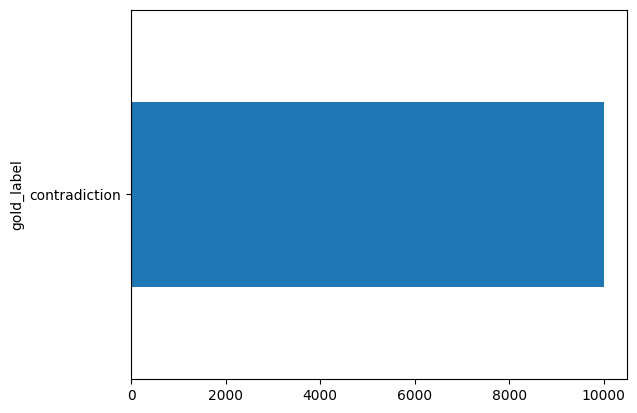

In [4]:
import pandas as pd

df = pd.read_csv('/kaggle/input/snli-sample/snli_1.0_sample_train.csv')
df['gold_label'].value_counts().plot(kind='barh')

We can see a few random contradiction examples here.

In [5]:
df[df['gold_label'] == 'contradiction'].sample(10)[['sentence1', 'sentence2']]

,sentence1,sentence2
1122,A person sits inside a small plane on the ground.,A person stands as they fly a plane.
4381,A rodeo with a man riding a bucking horse.,A man laying down on a bed.
3098,A skateboarder is doing a kick flip across a c...,A skateboarder tumbling mid-air.
162,A man in a turban that partially covers his fa...,woman in bikini
7239,girls singing at a talent show.,There are boys singing at a talent show.
9008,A blond girl wearing flannel and a brunette we...,The two girls are settling in for a good night...
6767,An African American woman looking at a poster.,An African American woman is watching a movie ...
8108,"Two women in pink saris, a woman in a black sa...",Nobody is wearing a sari.
1901,Two teammates attempt to convert a soccer goal...,All of the players are on the ground clutching...
8958,Man in orange coveralls works at a fresh seafo...,A group of dogs are playing cards at a table.


Now we can create a small function that takes  the contradictory sentences and converts the dataset instruct format.

In [6]:
def convert_to_format(row):
    sentence1 = row['sentence1']
    sentence2 = row['sentence2']

    prompt = """Below is an instruction that describes a task paired with input that provides further context. Write a response that appropriately completes the request."""
    instruction = """Given the following sentence, your job is to generate the negation for it in the json format"""
    input = str(sentence1)
    response = f"""```json
{{'orignal_sentence': '{sentence1}', 'generated_negation': '{sentence2}'}}
```
"""
    if len(input.strip()) == 0:  #  prompt + 2 new lines + ###instruction + new line + input + new line + ###response
        text = prompt + "\n\n### Instruction:\n" + instruction + "\n### Response:\n" + response
    else:
        text = prompt + "\n\n### Instruction:\n" + instruction + "\n### Input:\n" + input + "\n" + "\n### Response:\n" + response

    # we need 4 columns for auto train, instruction, input, output, text
    return pd.Series([instruction, input, response, text])

In [7]:
new_df = df[['sentence1', 'sentence2']].apply(convert_to_format, axis=1)
new_df.columns = ['instruction', 'input', 'output', 'text']

new_df.to_csv('snli_instruct.csv', index=False)

In [8]:
new_df

,instruction,input,output,text
0,"Given the following sentence, your job is to g...",An older man reads a newspaper in front of a s...,```json\n{'orignal_sentence': 'An older man re...,Below is an instruction that describes a task ...
1,"Given the following sentence, your job is to g...",Two girls playing at a playground.,```json\n{'orignal_sentence': 'Two girls playi...,Below is an instruction that describes a task ...
2,"Given the following sentence, your job is to g...","Two men in hats, one playing a banjo and one p...",```json\n{'orignal_sentence': 'Two men in hats...,Below is an instruction that describes a task ...
3,"Given the following sentence, your job is to g...",Young girl carries a bouquet of flowers.,```json\n{'orignal_sentence': 'Young girl carr...,Below is an instruction that describes a task ...
4,"Given the following sentence, your job is to g...",The crowd is gathered to watch a sporting event.,```json\n{'orignal_sentence': 'The crowd is ga...,Below is an instruction that describes a task ...
...,...,...,...,...
9995,"Given the following sentence, your job is to g...",A little girl playing in the fall leaves.,```json\n{'orignal_sentence': 'A little girl p...,Below is an instruction that describes a task ...
9996,"Given the following sentence, your job is to g...",two men in hi-viz jackets are talking to a man...,```json\n{'orignal_sentence': 'two men in hi-v...,Below is an instruction that describes a task ...
9997,"Given the following sentence, your job is to g...",A mother and her kids taking a family picture.,```json\n{'orignal_sentence': 'A mother and he...,Below is an instruction that describes a task ...
9998,"Given the following sentence, your job is to g...",Two babies are sitting close together while re...,```json\n{'orignal_sentence': 'Two babies are ...,Below is an instruction that describes a task ...


Here is an example of the sample data point:



In [9]:
new_df["text"][23]

"Below is an instruction that describes a task paired with input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nGiven the following sentence, your job is to generate the negation for it in the json format\n### Input:\nA young boy wearing safety glasses uses a hammer to break up rocks while a man in plaid pants stands nearby leaning on a cane.\n\n### Response:\n```json\n{'orignal_sentence': 'A young boy wearing safety glasses uses a hammer to break up rocks while a man in plaid pants stands nearby leaning on a cane.', 'generated_negation': 'A boy and a man look at insects in a park.'}\n```\n"

You can convert it to the Hugging Face dataset format easily using from_pandas method, this will be helpful in training the model.

In [10]:
from datasets import Dataset

dataset = Dataset.from_pandas(new_df)

/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [11]:
print(dataset)

Dataset({
    features: ['instruction', 'input', 'output', 'text'],
    num_rows: 10000
})


## 4. Quantized Model
We will be using the already quantized LLamav2 model which is provided by abhishek/llama-2–7b-hf-small-shards. Let’s define some hyperparameters and variables here:

In [4]:
# The model that you want to train from the Hugging Face hub
model_name = "abhishek/llama-2-7b-hf-small-shards"

# Fine-tuned model name
new_model = "llama-2-negator"


 QLoRA parameters

In [13]:
# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

 bitsandbytes parameters

In [14]:
# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

TrainingArguments parameters

In [15]:
# Output directory where the model predictions and checkpoints will be stored
output_dir = "./outputs"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 32

# Batch size per GPU for evaluation
per_device_eval_batch_size = 32

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 1e-5

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"


# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 100

SFT parameters

In [16]:
# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

device_map = "auto"

We can now simply use BitsAndBytesConfig class to create the config for 4-bit fine-tuning.

In [17]:
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

Now we can load the base model with 4 bit BitsAndBytesConfig and tokenizer for Fine-Tuning.

In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

We can now create the LoRA config and set the training parameters.

In [19]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

In [20]:
# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

Now we can simply use SFTTrainer which is provided by trl from HuggingFace to start the training.

In [21]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",  # this is the text column in dataset
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()


/opt/conda/lib/python3.10/site-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?ba/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
100,2.168500
200,1.362800
300,0.958000


TrainOutput(global_step=313, training_loss=1.4730153556068104, metrics={'train_runtime': 7769.9234, 'train_samples_per_second': 1.287, 'train_steps_per_second': 0.04, 'total_flos': 2.83033779830784e+16, 'train_loss': 1.4730153556068104, 'epoch': 1.0})

## 5. Save the model

In [23]:
# Save trained model
trainer.model.save_pretrained(new_model)

You need to load the base model again and merge it with the fine-tuned LoRA matrices. This can be done using merge_and_unload() function.

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    "abhishek/llama-2-7b-hf-small-shards",
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="auto",
)

model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)

Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


## 6. Inference
You can test your model by simply passing in the inputs in the same prompt template that we have defined above.

In [16]:
import re
import json

def format_results(s):
    pattern = r'```json\n(.*?)\n```'

    # Find all occurrences of JSON objects in the string
    json_matches = re.findall(pattern, s, re.DOTALL)
    if not json_matches:
        # try to find 2nd pattern
        pattern = r'\{.*?"sentence":.*?"negation":.*?\}'
        json_matches = re.findall(pattern, s)

    # Return the first JSON object found, or None if no match is found
    return json.loads(json_matches[0]) if json_matches else None

In [17]:
prompt_template = """### Instruction:
Given the following sentence, your job is to generate the negation for it in the json format
### Input:
{}

### Response:
"""

sentence = "Suraj is trying to beat the Hari and wanting him to be dead."

input_sentence = prompt_template.format(sentence.strip())

result = pipe(input_sentence)
print(format_results(result[0]["generated_text"]))

{'sentence': 'Suraj is trying to beat the Hari and wanting him to be dead.', 'negation': 'Suraj is not trying to beat the Hari and wanting him to be dead.'}


In [18]:
prompt_template = """### Instruction:
Given the following sentence, your job is to generate the negation for it in the json format
### Input:
{}

### Response:
"""

sentence = "I always hope to buy a brand new tesla."

input_sentence = prompt_template.format(sentence.strip())

result = pipe(input_sentence)
print(format_results(result[0]["generated_text"]))

{'sentence': 'I always hope to buy a brand new tesla.', 'negation': 'I never hope to buy a brand new tesla.'}


In [19]:
prompt_template = """### Instruction:
Given the following sentence, your job is to generate the negation for it in the json format
### Input:
{}

### Response:
"""

sentence = "The weather forecast predicts a sunny day with a high temperature around 30 degrees Celsius, perfect for a day at the beach with friends and family."

input_sentence = prompt_template.format(sentence.strip())

result = pipe(input_sentence)
print(format_results(result[0]["generated_text"]))

{'sentence': 'The weather forecast predicts a sunny day with a high temperature around 30 degrees Celsius, perfect for a day at the beach with friends and family.', 'negation': 'The weather forecast predicts a rainy day with a low temperature around 10 degrees Celsius, not ideal for a day at the beach with friends and family.'}


## 7. Conclusion
With only a single epoch training, we got able to produce good result.